# The Schrödinger equation
#### Let's have some serious fun!
We'll look at the solutions of the Schrödinger equation for a harmonic potential. 

In [1]:
import numpy as np
import math
from math import pi as Pi
import matplotlib.pyplot as plt
from scipy import (inf, integrate)
import seaborn as sns
sns.set()

### Prelude: Hermite's Polynomials

Hermite's Polynomials are a subset of polynomials that will help us construct solutions of the Schrödinger equation. 

#### Polynomials
Some object-oriented Python programming with polynomials. We represent an arbitrary polynomial

$$
P(x) = \sum_{n=0}^{N} p_n \cdot x^n
$$

unambiguously by its coefficients $p_n$, i.e. an array of real numbers of length $N+1$. Apart from the algebraic operators we also define the multiplication with x as ```mulx()``` and the differentiation as  ```d_dx()```. 

In [2]:
class Polynomial():
    """
        A class representing a polynomial by its coefficients
    """
    
    def __init__(self, array=[0]):
        self.p = np.array(array)
        
    def mulx(self):
        return Polynomial(np.insert(self.p, 0, 0))

    def d_dx(self):
        return Polynomial([i*self.p[i] for i in range(1, len(self.p))])    

    def __eq__(self, other):
        return np.equal(self.p, other.p).all()
    
    def __rmul__(self, number):
        return Polynomial(number * self.p)
    
    def __sub__(self, other):
        l=max(len(self.p), len(other.p))
        return Polynomial(Polynomial.pad(self.p,l) - Polynomial.pad(other.p,l))

    def __add__(self, other):
        l=max(len(self.p), len(other.p))
        return Polynomial(Polynomial.pad(self.p,l) + Polynomial.pad(other.p,l))

    def __call__(self, x):
        return np.sum([self.p[i] * x**i for i in range(len(self.p))], axis=0)
    
    @staticmethod
    def pad(array, l):
        if len(array) == l:
            return array
        if len(array) > l:
            raise ValueError("can't pad to lower dimension")
        return np.append(array, np.zeros(l-len(array)))

    @staticmethod
    def mono_repr(c, i):
        if c==0:
            return ''
        if i==0:
            return str(int(c))
        elif i==1:
            return "{}x".format(int(c))
        else:
            if c==1:
                return "x^{}".format(i)
            else:
                return "{}x^{}".format(int(c),i)    

    def __repr__(self):
        return " + ".join( 
            np.flipud([Polynomial.mono_repr(self.p[i],i) 
                      for i in range(len(self.p)) if self.p[i] != 0] ))

#### The Hermite Polynomial generator
Now, Hermite's polynomials are a special subset of all polynomials, defined e.g. by a recursion relation:

From [Wikipedia](https://en.wikipedia.org/wiki/Hermite_polynomials) (if not good memories), we know that
$$
H_n(x) = (2x-\frac{d}{dx})^n \cdot 1
$$

generates the *physicist's* Hermite polynomials. We define our python generator in a recursive fashion returning Polynomial instances

$$
H_n(x) = (2x-\frac{d}{dx}) \cdot H_{n-1}
$$

In [56]:
def H(n):
    if n<0:
        raise ValueError("Not defined for negativ n")
    if n==0:
        return Polynomial([1])
    p = H(n-1)
    return 2 * p.mulx() - p.d_dx()

Note that we can evaluate the polynomial at any (even complex) x.

In [57]:
H_3 = H(3)
H_3, H_3(1), H_3(1+2j)

(8x^3 + -12x, -4.0, (-100-40j))

The Hermite polynomials have the special properties:

$$
    x \cdot H_\nu(x) = \frac{1}{2} H_{\nu+1}(x) + \nu \cdot H_{\nu-1}(x)
$$

$$
    \frac{d}{dx}H_\nu(x) = 2 \nu \cdot H_{\nu-1}(x)
$$

Let's verify our implementation for the first 10 polynomials ($\nu = {0..9}$):

In [58]:
[H(nu).mulx() == .5 * H(nu+1) + nu*H(nu-1) for nu in range(1,10)]

[True, True, True, True, True, True, True, True, True]

In [59]:
[H(nu).d_dx() == 2 * nu * H(nu - 1) for nu in range(1,10)]

[True, True, True, True, True, True, True, True, True]

---
### The time-dependent Schrödinger equation

$$
i\hbar \frac{\partial \Psi(x,t)}{\partial t} = 
\mathcal{H}\Psi(x,t) =
E\Psi(x,t)
$$

This is the Schrödinger equation. Now, with the time-independent Hamilton operator $\mathcal{H}$ for a particle with mass m and the harmonic potential given by $ V(x)=\frac{1}{2}m\omega^2 x^2$ looks like
 
$$
\mathcal{H} = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + \frac{1}{2}m\omega^2 x^2 
$$

we can separate the variables $x$ and $t$ like so:

$$
\Psi(x, t) = \psi(x) \cdot \varphi(t)
$$


and solve both 
$$
i\hbar \frac{\partial \varphi(t)}{\partial t} = E \cdot \varphi(t)
$$

and

$$
[-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + \frac{1}{2}m\omega^2 x^2] \cdot \psi(x) = E \psi(x)
$$

separately.

A neat trick to get rid of the physical constants is rescaling:

$$\xi = \frac{m \omega}{\hbar} \cdot x$$

with which you can easily check by yourself that the Schrödinger equation becomes:

$$ 
[ -\frac{\partial^2}{\partial \xi^2} + \xi^2 - \frac{2E}{\hbar \omega}] \cdot \psi(\xi) = 0
$$

where we postulate the boundary conditions for a constrained particle as 

$$
\psi(-\infty) = \psi(\infty) = 0
$$

The so-called stationary solutions of the equation in $x$ form an ortho-normal eigenbasis of the Hilbert space of bounded functions $\psi_{\nu}(\xi)$ with eigenvalues $E_{\nu}=\hbar \omega (\nu + \frac{1}{2})$. And although we're not interested in the boring (yawn!) stationary solutions, we'll use this eigenbasis to construct an analytical function that obeys the time-dependent Schrödinger equation.


With the above eigenvalues we finally arrive at the following concise representation of the time-independent Schrödinger equation.

$$ 
[ -\frac{\partial^2}{\partial \xi^2} + \xi^2 - (2\nu+1)] \cdot \psi(\xi) = 0
$$

### Functions as eigenvectors

The solutions of this function span a vector space, a so-called Hilbert space. That means we can define addition, multiplication by a number and even an inner product on these functions. When we look at functions as vectors in a Hilbert space, then the Schrödinger equation can as well be considered an eigenvalue problem. We'll provide the solutions without proof.

The eigenfunctions are composed of the Hermite polynomials and a gaussian:

$$
\psi_\nu(\xi) = \frac{1}{\sqrt{2^\nu \cdot \nu! \cdot \sqrt{\pi}}} \cdot H_\nu(\xi) \cdot
e^{-\frac{\xi^2}{2}}
$$

$$
\varphi_\nu(t) = e^{-i (\nu+\frac{1}{2}) t}
$$
Thus arriving at the full solution of the time-dependent Schrödinger equation as

$$
\psi_\nu(\xi, t) = \frac{1}{\sqrt{2^\nu \cdot \nu! \cdot \sqrt{\pi}}} \cdot H_\nu(\xi) \cdot
e^{-\frac{\xi^2}{2}-i(\nu+\frac{1}{2}) t}
$$

These solutions are called stationary because they rotate in the complex plane keeping their shape. That means that for every x the value of $\psi_\nu(x)$ rotates in the complex plane with exactly the same *frequency* as any other. Please note that we have clandestinely scaled the time t such that it *swallowed* the physical constants. For our purpose, namely visualizing the non-stationary solutions of the Schrödinger equation, this does not make a difference.

---
Defining the normalization factor $A_\nu$ as 

$$
A_\nu = \frac{1}{\sqrt{2^\nu \cdot \nu! \cdot \sqrt{\pi}}}
$$

we visualize these stationary solutions such that we get an idea what they look like: 

In [7]:
def A(nu):
    return 1/math.sqrt(2**nu * math.factorial(nu) * math.sqrt(math.pi))

def psi(nu):
    def _psi(x):
        return A(nu) * H(nu)(x) * np.exp(-x*x/2)        
    return _psi

In [8]:
N_points=200

In [48]:
x_ = np.linspace(-6, 6, N_points)

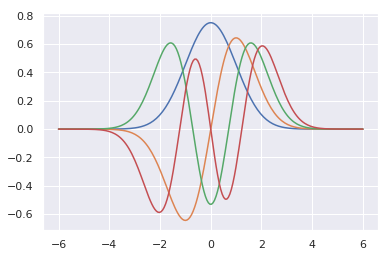

In [50]:
plt.plot(x_, psi(0)(x_))
plt.plot(x_, psi(1)(x_))
plt.plot(x_, psi(2)(x_))
plt.plot(x_, psi(3)(x_));

---
#### Ortho-normal basis
Let's verify that our $\psi_\nu(\xi)$ form an ortho-normal basis with the inner product $\langle \psi_\mu | \psi_\nu \rangle$, $\mathbb{H} \times \mathbb{H} \rightarrow \mathbb{R}$ defined by

$$
\int_{-\infty}^{\infty} \bar{\psi}_\nu(\xi) \cdot \psi_\mu(\xi) d\xi= \delta^{\mu\nu}
$$

$\bar{\psi}_\nu(\xi)$ being the complex conjugate of $\psi_\nu(\xi)$

In [51]:
[[round(integrate.quad(lambda x: psi(mu)(x)*psi(nu)(x), -inf, +inf)[0], 6) for mu in range(5)] for nu in range(5)]

[[1.0, 0.0, 0.0, 0.0, -0.0],
 [0.0, 1.0, 0.0, -0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, -0.0],
 [0.0, -0.0, 0.0, 1.0, 0.0],
 [-0.0, 0.0, -0.0, 0.0, 1.0]]

You can see that all inner products of two basis functions are zero, apart from the product with itself, which is what the *Kronecker* delta $\delta^{\mu \nu}$ demands.

---
### The fun part: coherent solutions

Now, let's have some fun. As we have just verified, the eigenstates of the Schrödinger equation form an ortho-normal basis of the Hilbert space of contrained functions in one dimension. We expect that one can approximate any other bounded function as a linear combination of the first $N$ eigenfunctions. We'll do that for the following shifted gaussian. Note that is is centered around $x=-3$, so it's not equal to the first basis function.

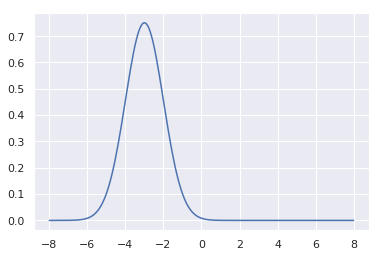

In [12]:
x0=-3
fun=lambda x: psi(0)(x-x0)
#sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": .1})
sns.set()
plt.plot(x_, fun(x_));

We compute it's coordinates in the Schrödinger eigenbases simply by projecting it to the first $N$ eigenfunctions like this

In [13]:
N = 15
coords = [integrate.quad(lambda x: psi(mu)(x)*fun(x), -inf, +inf)[0] for mu in range(N)]
coords

[0.10539922456186752,
 -0.22358551925849393,
 0.33537827888774097,
 -0.4107528270438987,
 0.43566916409142903,
 -0.4133120594491675,
 0.3579387431734438,
 -0.2869894590873224,
 0.21524209431549288,
 -0.1521991444872781,
 0.1020982899572428,
 -0.06530228567262489,
 0.03998931973389909,
 -0.023527652499053843,
 0.013338925166922012]

Calling those coordinates $c_\nu$, we compute 

$$
\psi_0(x-x_0) \approx \big[\sum_{\nu=0}^9 c_\nu \cdot A_\nu H_\nu(x)\big] \cdot e^{-\frac{-x^2}{2}}
$$

In [14]:
pol = Polynomial([0])
for nu in range(N):
    pol = pol + coords[nu] * A(nu) * H(nu)

projection = lambda x: pol(x) * np.exp(-x*x/2)

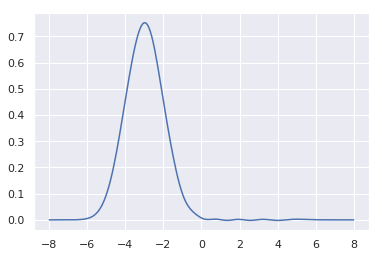

In [15]:
plt.plot(x_, projection(x_));

What you see is that the 15-dimensional projection of our shifted function into the Schrödinger eigenbasis is a formidable approximation. 

It's actually much more than an approximation. You can interpret this function as the wave function of a particle resting (the momentum is zero) at $x=x_0$. Remember there's still the harmonic potential. Thus, in the limit of classical mechanics, we would expect that our particle will slowly accelerate to the right until it *feels* the potential there. Then it would reflect and move all the way back. Lacking friction, we indeed expect that this oscillation continues until eternity.

---
#### Let the clock tick...
Because now we have this function as a linear combination of Schrödinger solutions, we can switch on time and see ourselves. Under the influence of the time-dependent Schrödinger equation, the the fifteen eigenvectors each rotate at their own frequency determined by the eigenvalue $2\nu+1$ 

The time-dependent solutions

$$
\psi_\nu(\xi, t) = \frac{1}{\sqrt{2^\nu \cdot \nu! \cdot \sqrt{\pi}}} \cdot H_\nu(\xi) \cdot
e^{-\frac{\xi^2}{2}-i(\nu+\frac{1}{2}) t}
$$

Note that now this function is complex-valued!

In [16]:
def psit(nu):
    def _psi(x, t):
        return A(nu) * H(nu)(x) * np.exp(-x*x/2) * np.exp(-1j*(nu+.5)*t)
    return _psi

psit(3)(1, .3)

(-0.07938026140540554+0.13838482501850966j)

---
#### 3-D data 
To appreciate the dynamics of a wave function in time we display both the real part and the imaginary part.

- The figure's y-axis is our space coordinate $x$
- its z-axis spans the real part of the wave function
- and its x-axis spans the wave function's imaginary part

In [19]:
import mpl_toolkits.mplot3d.axes3d as p3

In [53]:
x_ = np.linspace(-6,6, N_points)
f = psit(2)(x_, .5)
r_f = [c.real for c in f]
i_f = [c.imag for c in f]

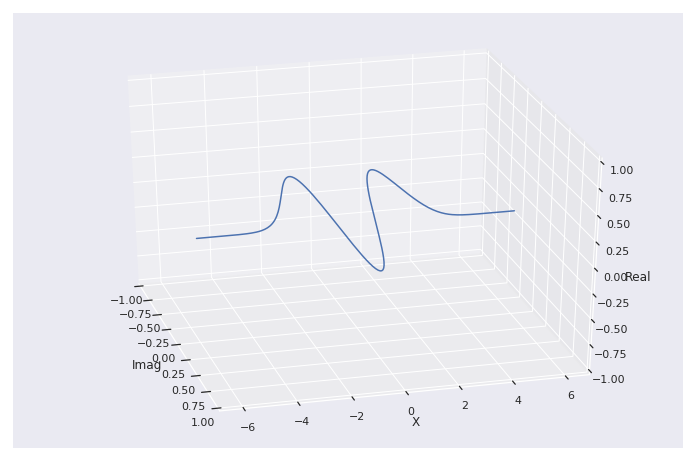

In [54]:
fig=plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.view_init(30, -15)
ax.set_xlim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('Imag')
ax.set_ylabel('X')
ax.set_zlabel('Real')
ax.plot(i_f, x_, r_f)
plt.show()

---
#### Time-dependent wave functions
Here, we'll create an analytical time-dependent wave function from our set of coordinates in Hilbert space that represent the resting particle at $x_0=-3$

In [60]:
def WF(sc):
    def _f(x, t):
        v = 0
        for nu in range(len(sc)):
            v += sc[nu] * A(nu) * H(nu)(x) * np.exp(-1j*(nu+.5)*t)
        return v * np.exp(-x*x/2)

    return _f

particle = WF(coords)

particle(-3, 0)

(0.45630699835458494+0j)

### Animating a Schrödinger particle!

In [61]:
%autosave 3600

Autosaving every 3600 seconds


#### Snapshot
A snapshot of a complex function at a point in time

In [62]:
N_frames=100
N_Points=200
XL, XR = -6, 6

In [63]:
def snapshot(N, f, t):
    x = np.linspace(XL,XR, N)
    f=f(x, t)
    r_f = np.array([c.real for c in f])
    i_f = np.array([c.imag for c in f])
    return np.array([i_f, x, r_f])

In [64]:
def update(num, n_points, n_frames, wave_function, line):
    data= snapshot(n_points, wave_function, num*4.0/n_frames*math.pi)
    line.set_data(data[0], data[1])
    line.set_3d_properties(data[2])
    return line

Recording the animation will take a couple of seconds. Be patient. It's worth waiting for!

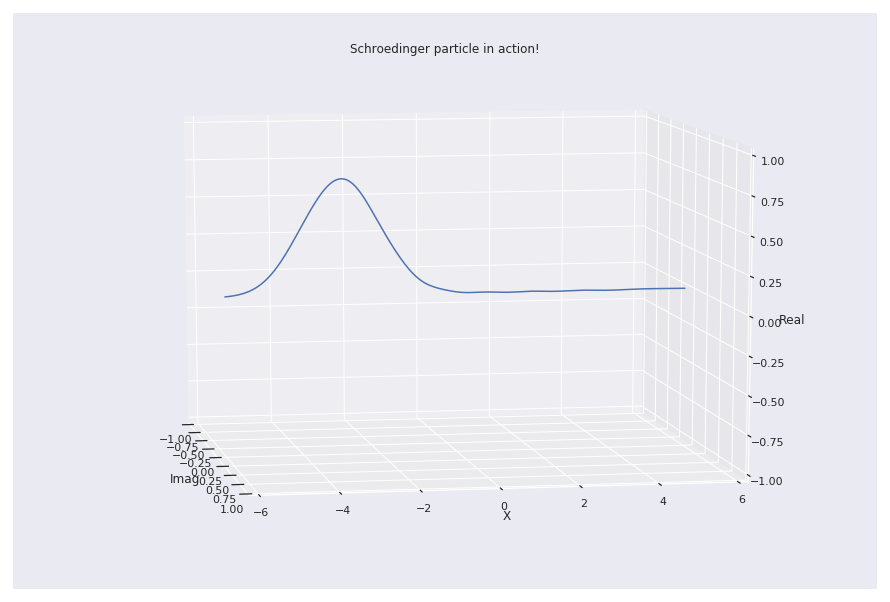

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

fig=plt.figure(figsize=(12,8))
ax = p3.Axes3D(fig)

initial_data = snapshot(N_points, particle, 0.0)

line = ax.plot(initial_data[0], initial_data[1], initial_data[2])[0]

ax.set_xlim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_ylim(XL, XR)
ax.set_xlabel('Imag')
ax.set_ylabel('X')
ax.set_zlabel('Real')

ax.set_title('Schroedinger particle in action!')
ax.view_init(10, -10)

line_ani = animation.FuncAnimation(
    fig, update, N_frames, 
    fargs=(N_Points, N_frames, particle, line), 
    interval=200, blit=False)

jshtml = line_ani.to_jshtml()

In [46]:
#HTML(data=jshtml)

In [47]:
with open("Schroedinger.html", "w") as file:
    file.write(jshtml)

---
### Measuring momentum

Inf the following, we denote eigenfunctions of the Schrödinger equation in angle notation 

$$
|\nu \rangle \equiv \psi_\nu(x,t)
$$

In our unit-free notation, and introducing a more concise notation for the partial derivative, the momentum operator $\hat{p}$ is defined by

$$
\hat{p} = -i \partial_x
$$

Operators in our Hilbert space will be written in *hat* notation. You have seen $\hat{p}$ already. The Hamilton operator becomes:

$$
\hat{H}  = \hat{p}^2 + \hat{x}^2
$$

Note that we're back to using $x$, but what we really mean is the unit-less $\xi$.

The Schrödinger equation in its eigenbasis looks like 

$$
\hat{H} |\nu\rangle = 2(\nu+1)|\nu\rangle 
$$

The inner product of any two wave functions (not necessarily basisvectors) as defined by the integral over the product of both functions has a neat short notation:

$$
\langle \psi_1 | \psi_2 \rangle
\equiv
\int_{-\infty}^{\infty} \bar{\psi_1}(\xi) \cdot \psi_2(\xi) d\xi
$$

The expectation value of an observable represented by an Operator like e.g. $\hat{p}$, given a particular wave function $\psi$ is defined by

$$
\langle \psi | \hat{p} | \psi \rangle
\equiv
\int_{-\infty}^{\infty} \bar{\psi}(\xi) \cdot (-i\partial_x) \psi(\xi) d\xi
$$


Let us introduce the two *ladder* operators $a$ and $a^\dagger$ as

$$
a \equiv \frac{1}{\sqrt 2} (\hat{x} + i\hat{p})
$$

$$
a^\dagger \equiv \frac{1}{\sqrt 2} (\hat{x} - i\hat{p})
$$

which can be written the other way round as

$$
\hat{p} = \frac{1}{\sqrt 2}(a^\dagger - ia)
$$

$$
\hat{x} = \frac{1}{\sqrt 2}(a^\dagger + ia)
$$

Then you can convince yourself easily using the properties of the Hermite polynomials:

$$
    x \cdot H_\nu(x) = \frac{1}{2} H_{\nu+1}(x) + \nu \cdot H_{\nu-1}(x)
$$

$$
    \frac{d}{dx}H_\nu(x) = 2 \nu \cdot H_{\nu-1}(x)
$$

and our solutions of the Schrödinger equations

$$
\psi_\nu(x) = A_\nu \cdot H_\nu(x) \cdot
e^{-\frac{x^2}{2}}
$$

that
$$ a|\nu\rangle = \sqrt{\nu} |\nu-1 \rangle $$ 
and
$$ a^\dagger|\nu\rangle = \sqrt{\nu+1} |\nu+1 \rangle $$ 

It should be obvious by now why these operators are called *ladder* operators. They map each basis vector on the next resp. previous basis vector. And this neat property leads to a surprisingly simple method of applying $\hat{p}$ or $\hat{x}$ to arbitrary wave functions.

In a matrix representation, the ladder operators populate the positions right above and below the diagonal.

$$
a = \left[
    \begin{array}{c c c c c c}
    0 & 1 & 0 & 0 & 0 & 0 & \dots \\
    0 & 0 & \sqrt{2} & 0 & 0 & 0 & \dots\\
    0 & 0 & 0 & \sqrt{3} & 0 & 0 & \dots\\
    0 & 0 & 0 & 0 & \sqrt{4} & 0 & \dots\\
    0 & 0 & 0 & 0 & 0 & \sqrt{5} & \dots\\
    0 & 0 & 0 & 0 & 0 & 0 & \dots \\
    \dots
    \end{array}
    \right]
$$

$$
a^\dagger = 
    \left[
    \begin{array}{c c c c c c}
    0 & 0 & 0 & 0 & 0 & 0 & \dots\\
    1 & 0 & 0 & 0 & 0 & 0 & \dots\\
    0 & \sqrt{2} & 0 & 0 & 0 & 0 & \dots\\
    0 & 0 & \sqrt{3} & 0 & 0 & 0 & \dots\\
    0 & 0 & 0 & \sqrt{4} & 0 & 0 & \dots\\
    0 & 0 & 0 & 0 & \sqrt{5} & 0 & \dots\\
    \dots
    \end{array}
    \right]
$$    
    
$$
\hat{p} = \left[
    \begin{array}{c c c c c c}
    0 & -i & 0 & 0 & 0 & 0 & \dots\\
    1 & 0  & -i\sqrt{2} & 0 & 0 & 0 & \dots\\
    0 & \sqrt{2} & 0 & -i\sqrt{3} & 0 & 0 & \dots\\
    0 & 0 & \sqrt{3} & 0 & -i\sqrt{4} & 0 & \dots\\
    0 & 0 & 0 & \sqrt{4} & 0 & -i\sqrt{5} & \dots\\
    0 & 0 & 0 & 0 & \sqrt{5} & 0 & \dots\\
    \dots
    \end{array}
    \right]
$$

$$
\hat{x} = \left[
    \begin{array}{c c c c c c}
    0 & i & 0 & 0 & 0 & 0 & \dots\\
    1 & 0  & i\sqrt{2} & 0 & 0 & 0 & \dots\\
    0 & \sqrt{2} & 0 & i\sqrt{3} & 0 & 0 & \dots\\
    0 & 0 & \sqrt{3} & 0 & i\sqrt{4} & 0 & \dots\\
    0 & 0 & 0 & \sqrt{4} & 0 & i\sqrt{5} & \dots\\
    0 & 0 & 0 & 0 & \sqrt{5} & 0 & \dots\\
    \dots
    \end{array}
    \right]
$$
